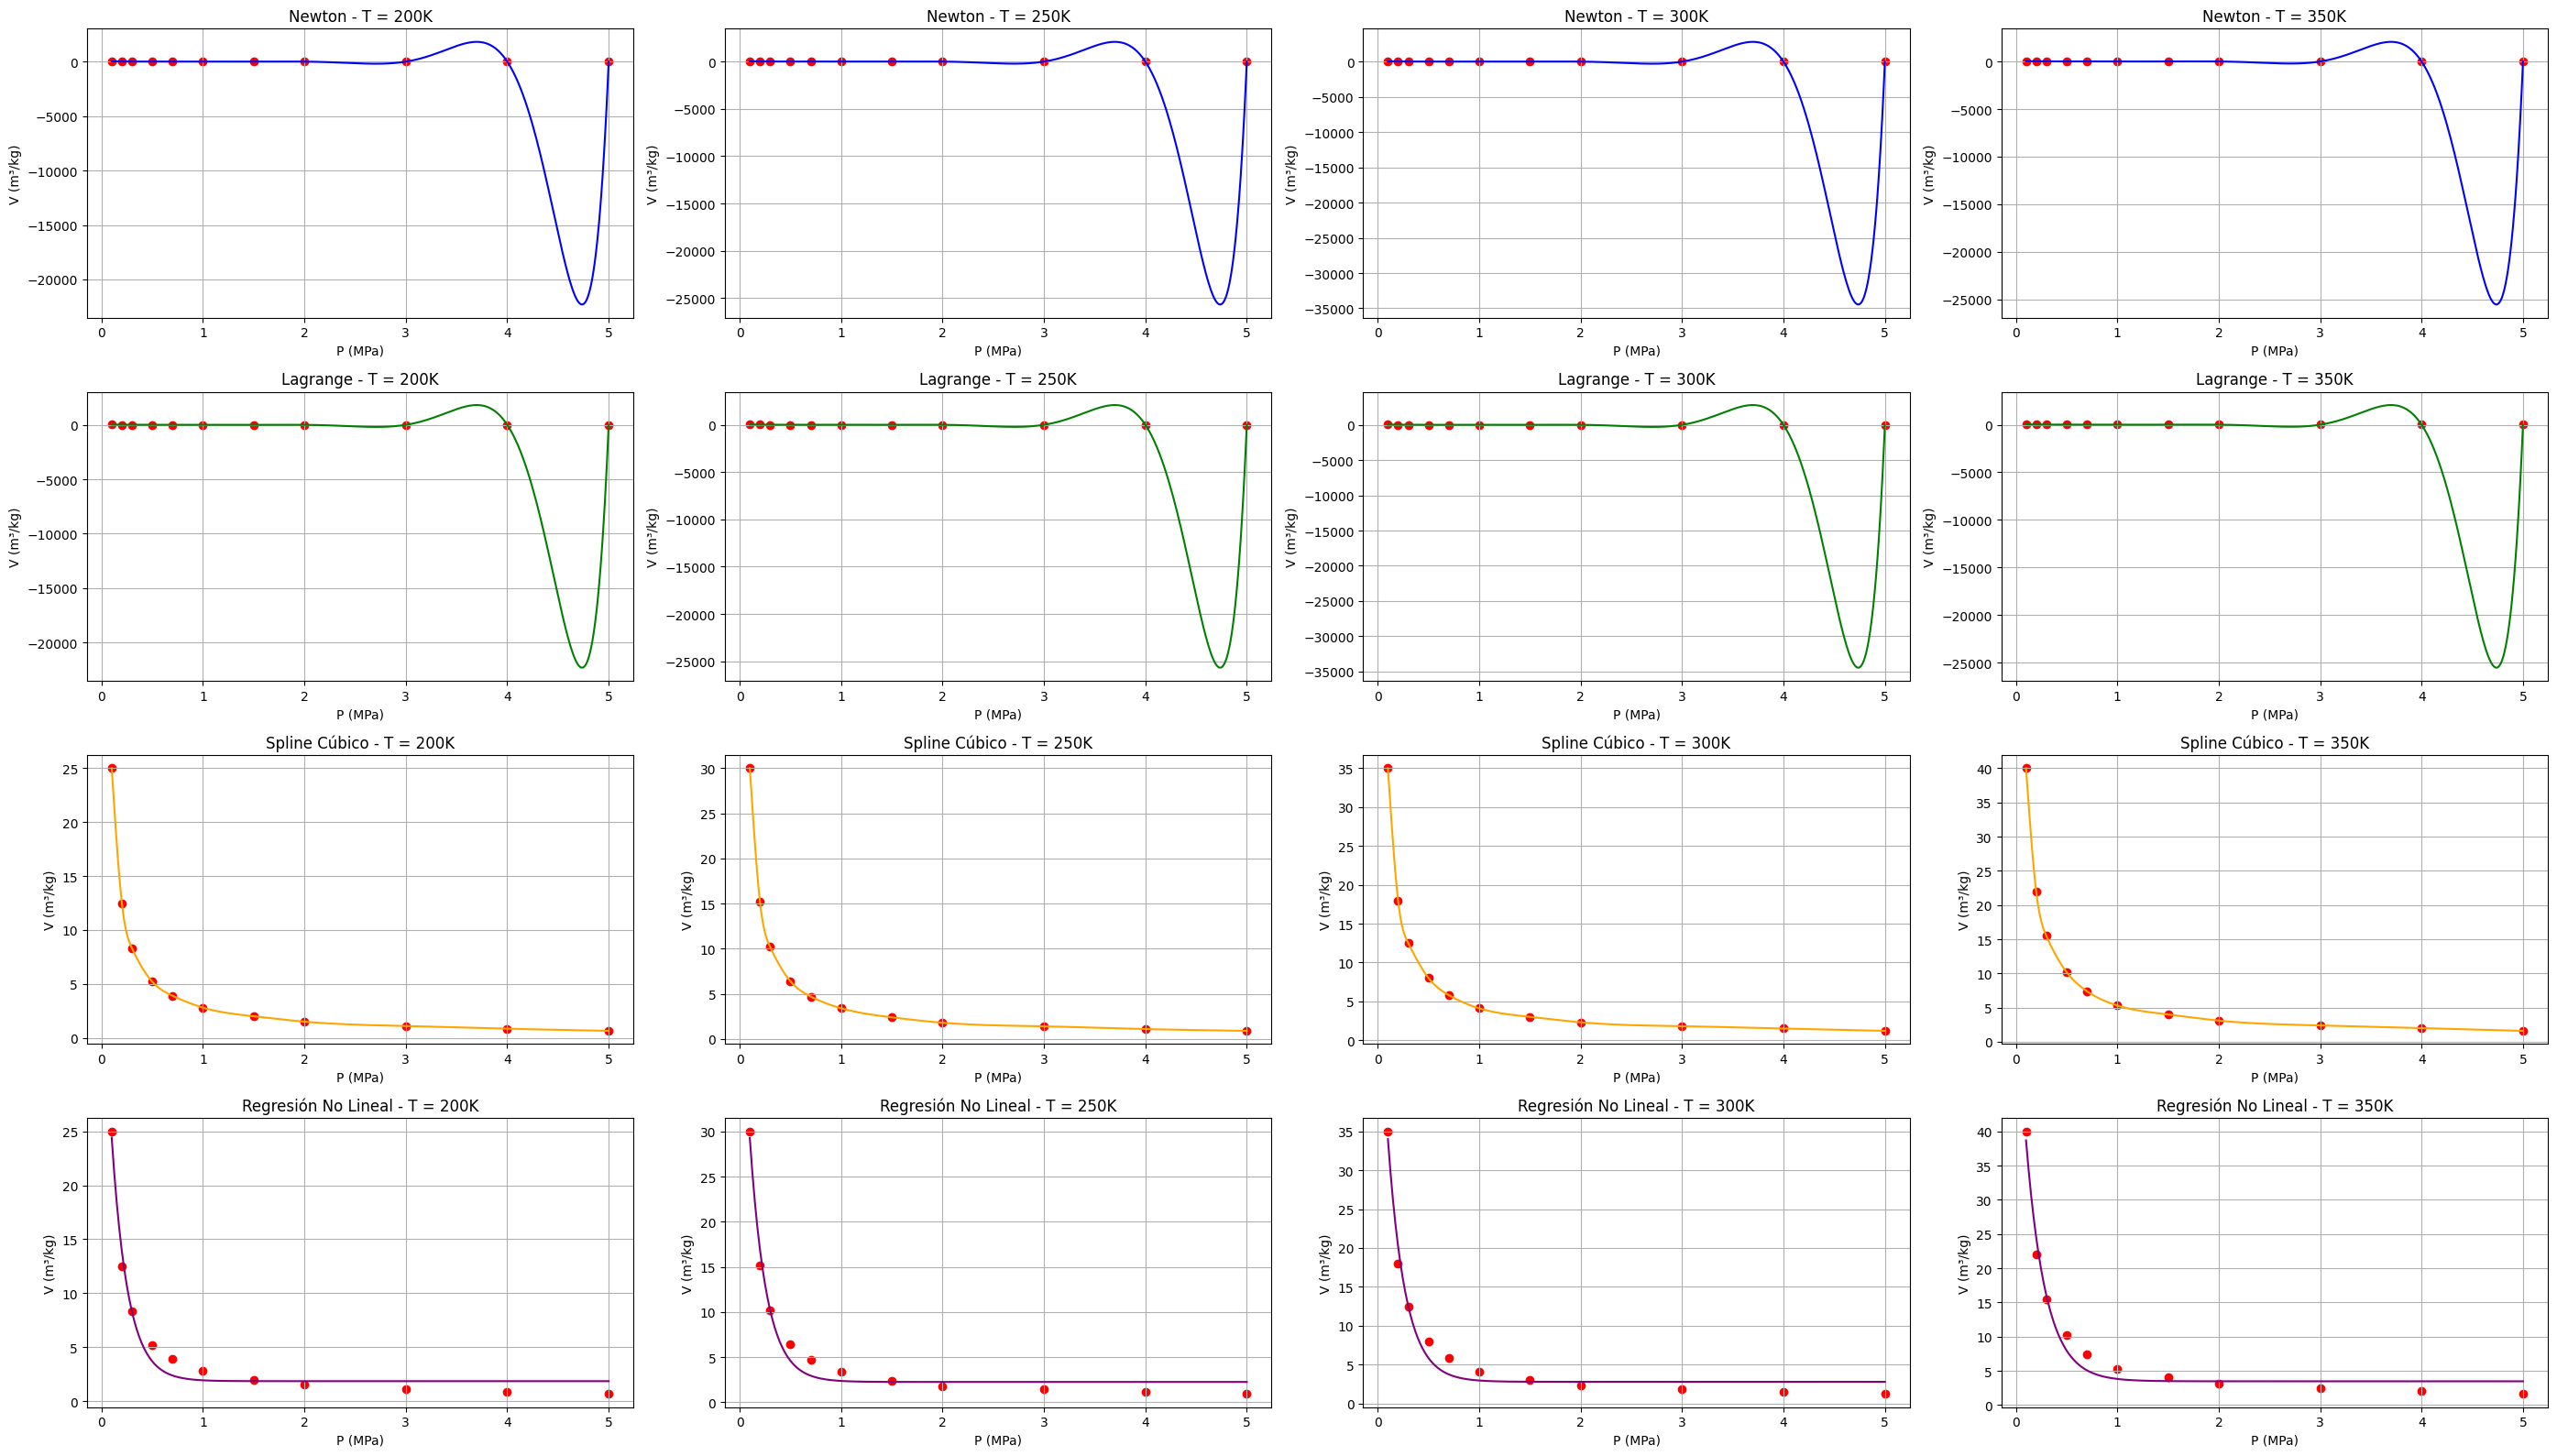

In [1]:
import numpy as np
from sympy import symbols, simplify, lambdify, prod
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

def diferencias_divididas(x, y):
    n = len(y)
    coef = np.zeros([n, n])
    coef[:, 0] = y
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])
    return coef

def construir_polinomio_simplificado(coef, x):
    x_sym = symbols('x')
    n = len(coef[0])
    polinomio = coef[0, 0]
    terminos = 1
    polinomio_expr = polinomio
    for i in range(1, n):
        terminos *= (x_sym - x[i-1])
        polinomio_expr += coef[0, i] * terminos
    return simplify(polinomio_expr)

def lagrange_interpolation(x, y):
    x_sym = symbols('x')
    n = len(x)
    polinomio = 0
    for i in range(n):
        L_i = prod((x_sym - x[j]) / (x[i] - x[j]) for j in range(n) if j != i)
        polinomio += y[i] * L_i
    return simplify(polinomio)

# Modelo no lineal: exponencial
def modelo_exponencial(x, a, b, c, d):
    return a * np.exp(-b * x / d) + c

# Diccionario con las 4 tablas
datos = {
    "200K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [25.0, 12.5, 8.3, 5.2, 3.9, 2.8, 2.0, 1.5, 1.1, 0.85, 0.65]
    },
    "250K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9]
    },
    "300K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [35.0, 18.0, 12.5, 8.0, 5.8, 4.1, 3.0, 2.3, 1.8, 1.5, 1.2]
    },
    "350K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [40.0, 22.0, 15.5, 10.2, 7.4, 5.3, 4.0, 3.1, 2.4, 2.0, 1.6]
    }
}

# Crear figura con 4 filas y 4 columnas
fig, axes = plt.subplots(4, 4, figsize=(28, 16))
x_sym = symbols('x')

for idx, (T, valores) in enumerate(datos.items()):
    x = np.array(valores["P"])
    y = np.array(valores["V"])
    x_vals = np.linspace(x.min(), x.max(), 400)

    # Newton
    coef = diferencias_divididas(x, y)
    poly_newton = construir_polinomio_simplificado(coef, x)
    f_newton = lambdify(x_sym, poly_newton, 'numpy')
    y_vals_newton = f_newton(x_vals)

    ax_newton = axes[0, idx]
    ax_newton.plot(x_vals, y_vals_newton, color="blue")
    ax_newton.scatter(x, y, color="red")
    ax_newton.set_title(f"Newton - T = {T}")
    ax_newton.set_xlabel("P (MPa)")
    ax_newton.set_ylabel("V (m³/kg)")
    ax_newton.grid(True)

    # Lagrange
    poly_lagrange = lagrange_interpolation(x, y)
    f_lagrange = lambdify(x_sym, poly_lagrange, 'numpy')
    y_vals_lagrange = f_lagrange(x_vals)

    ax_lagrange = axes[1, idx]
    ax_lagrange.plot(x_vals, y_vals_lagrange, color="green")
    ax_lagrange.scatter(x, y, color="red")
    ax_lagrange.set_title(f"Lagrange - T = {T}")
    ax_lagrange.set_xlabel("P (MPa)")
    ax_lagrange.set_ylabel("V (m³/kg)")
    ax_lagrange.grid(True)

    # Spline cúbico
    cs = CubicSpline(x, y, bc_type='natural')
    y_vals_spline = cs(x_vals)

    ax_spline = axes[2, idx]
    ax_spline.plot(x_vals, y_vals_spline, color="orange")
    ax_spline.scatter(x, y, color="red")
    ax_spline.set_title(f"Spline Cúbico - T = {T}")
    ax_spline.set_xlabel("P (MPa)")
    ax_spline.set_ylabel("V (m³/kg)")
    ax_spline.grid(True)

    # Regresión no lineal (modelo exponencial)
    try:
        parametros_iniciales = [max(y), 1, min(y), 1]
        parametros, _ = curve_fit(modelo_exponencial, x, y, p0=parametros_iniciales)
        y_fit = modelo_exponencial(x_vals, *parametros)

        ax_nl = axes[3, idx]
        ax_nl.plot(x_vals, y_fit, color="purple")
        ax_nl.scatter(x, y, color="red")
        ax_nl.set_title(f"Regresión No Lineal - T = {T}")
        ax_nl.set_xlabel("P (MPa)")
        ax_nl.set_ylabel("V (m³/kg)")
        ax_nl.grid(True)
    except RuntimeError:
        # En caso de que curve_fit no converja
        axes[3, idx].text(0.5, 0.5, 'Ajuste fallido', ha='center', va='center', fontsize=12)
        axes[3, idx].set_title(f"Regresión No Lineal - T = {T}")
        axes[3, idx].grid(True)

plt.tight_layout()
plt.show()

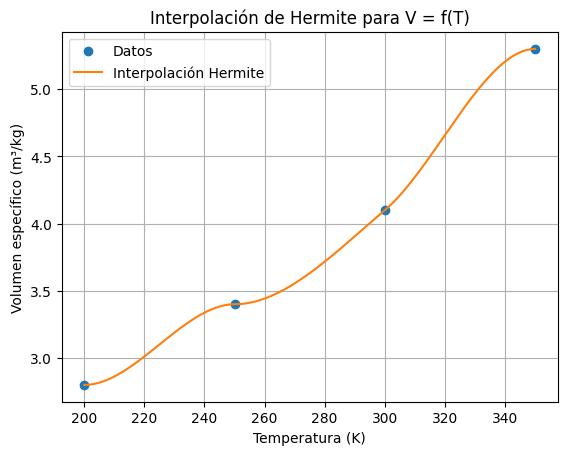

Volumen a 275 K: 3.6312 m³/kg
Volumen a 320 K: 4.6592 m³/kg


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

# Datos
T = np.array([200, 250, 300, 350])           # Temperaturas (K)
V = np.array([2.8, 3.4, 4.1, 5.3])           # Volumen específico (m³/kg)
dVdT = np.array([0.0, 0.0, 0.019, 0.0])      # Derivadas dV/dT (m³/kg·K)

# Crear la interpolación de Hermite
hermite = CubicHermiteSpline(T, V, dVdT)

# Valores para evaluar
T_vals = np.linspace(200, 350, 300)
V_vals = hermite(T_vals)

# Graficar
plt.plot(T, V, 'o', label='Datos')
plt.plot(T_vals, V_vals, '-', label='Interpolación Hermite')
plt.title("Interpolación de Hermite para V = f(T)")
plt.xlabel("Temperatura (K)")
plt.ylabel("Volumen específico (m³/kg)")
plt.legend()
plt.grid(True)
plt.show()

def V_hermite(T):
    if 200 <= T <= 250:
        return -9.6e-6*T**3 + 0.00648*T**2 - 1.44*T + 108.4
    elif 250 < T <= 300:
        return -3.6e-6*T**3 + 0.00316*T**2 - 0.905*T + 88.4
    elif 300 < T <= 350:
        return -1.16e-5*T**3 + 0.01112*T**2 - 3.521*T + 372.8
    else:
        raise ValueError("Temperatura fuera del rango válido (200-350 K)")

# Ejemplo de uso:
print(f"Volumen a 275 K: {V_hermite(275):.4f} m³/kg")
print(f"Volumen a 320 K: {V_hermite(320):.4f} m³/kg")

In [3]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd

# Constantes universales y del metano
R = 8.314  # J/mol·K
Tc = 190.56  # K
Pc = 4.59e6  # Pa
w = 0.011  # Factor acéntrico

def calcular_parametros_peng_robinson(T, Tc, Pc, w):
    Tr = T / Tc
    k = 0.37 + 1.5 * w - 0.26 * w**2
    alpha = (1 + k * (1 - np.sqrt(Tr)))**2
    a = 0.45724 * R**2 * Tc**2 / Pc * alpha
    b = 0.07780 * R * Tc / Pc
    return a, b

def ecuacion_peng_robinson(V, P, T, a, b):
    return (R * T) / (V - b) - a / (V**2 + 2 * b * V - b**2) - P

def resolver_volumenes(P_exp, T, a, b):
    V_calc = []
    for P in P_exp:
        V_guess = R * T / P  # Estimación inicial
        V_solution, = fsolve(ecuacion_peng_robinson, V_guess, args=(P, T, a, b))
        V_calc.append(V_solution)
    return np.array(V_calc)

def calcular_errores(V_exp, V_calc):
    errores = np.abs(V_calc - V_exp)
    error_medio = np.mean(errores)
    return errores, error_medio

def mostrar_resultados(P_exp, V_exp, V_calc, errores, error_medio):
    tabla = pd.DataFrame({
        "P (MPa)": P_exp / 1e6,
        "V experimental (m³/kg)": V_exp,
        "V calculado (m³/kg)": V_calc,
        "Error absoluto (m³/kg)": errores
    })

    # Formatear solo la columna de presión con 1 decimal fijo
    tabla["P (MPa)"] = tabla["P (MPa)"].map(lambda x: f"{x:.1f}")
    
    print("\nResultados de la ecuación de Peng-Robinson para T = 250 K:\n")
    print(tabla.to_string(index=False))
    print(f"\nError medio absoluto: {error_medio:.6f} m³/kg")

if __name__ == "__main__":
    # Entrada de datos
    T = 250  # K
    P_exp = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]) * 1e6  # de MPa a Pa
    V_exp = np.array([30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9]) * 1e-3  # m³/kg

    # Calcular parámetros a y b
    a, b = calcular_parametros_peng_robinson(T, Tc, Pc, w)

    # Resolver volúmenes
    V_calc = resolver_volumenes(P_exp, T, a, b)

    # Calcular errores
    errores, error_medio = calcular_errores(V_exp, V_calc)

    # Mostrar resultados
    mostrar_resultados(P_exp, V_exp, V_calc, errores, error_medio)


Resultados de la ecuación de Peng-Robinson para T = 250 K:

P (MPa)  V experimental (m³/kg)  V calculado (m³/kg)  Error absoluto (m³/kg)
    0.1                  0.0300             0.020705                0.009295
    0.2                  0.0152             0.010312                0.004888
    0.3                  0.0102             0.006848                0.003352
    0.5                  0.0064             0.004077                0.002323
    0.7                  0.0047             0.002889                0.001811
    1.0                  0.0034             0.001998                0.001402
    1.5                  0.0024             0.001305                0.001095
    2.0                  0.0018             0.000959                0.000841
    3.0                  0.0014             0.000613                0.000787
    4.0                  0.0011             0.000440                0.000660
    5.0                  0.0009             0.000337                0.000563

Error medio ab

[Diagrama Peng-Robinson](diagrama_peng_robinson.png)

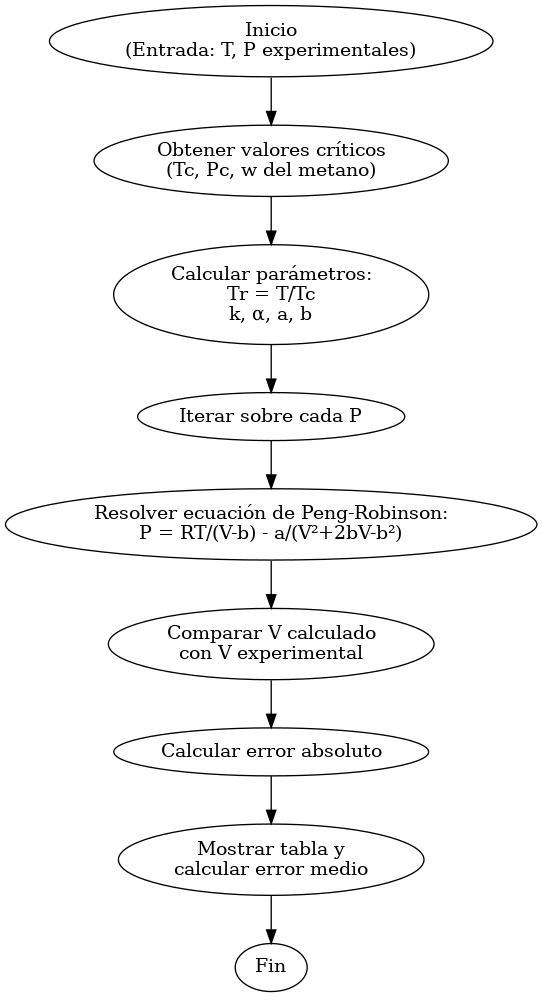

In [4]:
from IPython.display import Image

# Mostrar imagen directamente en el notebook
Image("diagrama_peng_robinson.png")

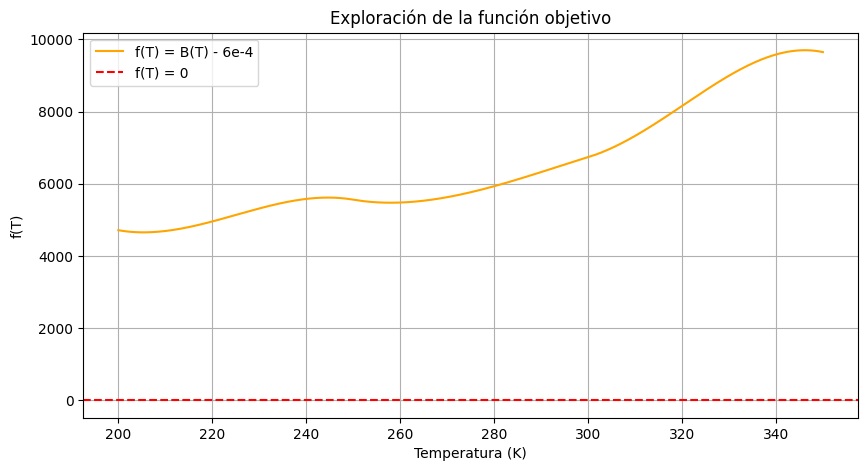

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
R = 8.314  # J/mol·K
P = 1e6    # Pa (1 MPa)
B_objetivo = 6e-4  # m^6/kg^2

# Función del volumen específico (V) por tramos
def V_hermite(T):
    if 200 <= T <= 250:
        return -9.6e-6*T**3 + 0.00648*T**2 - 1.44*T + 108.4
    elif 250 < T <= 300:
        return -3.6e-6*T**3 + 0.00316*T**2 - 0.905*T + 88.4
    elif 300 < T <= 350:
        return -1.16e-5*T**3 + 0.01112*T**2 - 3.521*T + 372.8
    else:
        raise ValueError("Temperatura fuera del rango válido (200-350 K)")

# Evaluamos la función f(T) = B(T) - B_objetivo
T_ext = np.linspace(200, 350, 1000)
f_ext = []

for T in T_ext:
    try:
        V = V_hermite(T)
        Z = P * V / (R * T)
        B_T = (Z - 1) * V
        f_ext.append(B_T - B_objetivo)
    except:
        f_ext.append(np.nan)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(T_ext, f_ext, label="f(T) = B(T) - 6e-4", color='orange')
plt.axhline(0, color='red', linestyle='--', label="f(T) = 0")
plt.xlabel("Temperatura (K)")
plt.ylabel("f(T)")
plt.title("Exploración de la función objetivo")
plt.legend()
plt.grid(True)
plt.show()

# Conclusión y Explicación

Al intentar determinar la temperatura a la que se alcanza un coeficiente del virial B(T) = 6×10⁻⁴ m⁶/kg² mediante el método de bisección, se observó lo siguiente:

1. **Modelo y Ecuación del Virial**  
   Se utiliza la aproximación de la ecuación del virial truncada:  
   Z = (P * V) / (R * T) ≈ 1 + [B(T) / V]  
   Despejando B(T) se obtiene:  
   B(T) ≈ [ (P * V) / (R * T) - 1 ] * V

2. **Función Objetivo para el Método de Bisección**  
   Se define la función objetivo:  
   f(T) = B(T) - 6×10⁻⁴  
   para buscar la raíz, es decir, la temperatura T que satisface f(T) = 0.

3. **Observación en el Intervalo T entre 200 K y 350 K**  
   Al evaluar f(T) en este rango (utilizando un modelo interpolado del volumen específico V(T) por tramos), se encontró que:  
   - **f(T) no cambia de signo:**  
     Esto indica que el valor B(T) calculado es siempre mucho mayor que 6×10⁻⁴ m⁶/kg² en todo el intervalo.  
   - **Implicación para el Método de Bisección:**  
     La ausencia de un cambio de signo implica que no existe un valor de T en el intervalo que haga f(T) = 0. Por lo tanto, el método de bisección no puede encontrar una raíz, y no se puede determinar el número de iteraciones necesarias para alcanzar errores de 0.01, 0.001 o 10⁻¹⁰.

4. **Conclusión Final**  
   - **No se encontró solución:**  
     Dado el modelo de V(T) y la presión P = 1 MPa, el valor B(T) = 6×10⁻⁴ m⁶/kg² no se alcanza dentro del rango de temperaturas analizado.
   - **Siguientes Pasos:**  
     Para poder obtener una solución (y, por ende, contar las iteraciones), se podría:  
     - Buscar un valor diferente de B(T) que sea alcanzable en el intervalo.  
     - Ajustar la presión P para modificar los valores de B(T).  
     - Utilizar una fórmula empírica para B(T) si se requiere otra aproximación.

Esta es la explicación y conclusión sobre por qué no se pudo determinar el número de iteraciones en el método de bisección para el B(T) dado.